In [1]:

#%pylab inline
#%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
import matplotlib.pyplot as plt


import numpy as np
import scipy.stats as stats

import pystan
import seaborn as sns
import scipy.special as sp



from jupyterthemes import jtplot

import vapeplot

jtplot.style(context='notebook', fscale=1)

In [2]:
vapeplot.set_palette('vaporwave')

In [3]:
def draw_redshift(zmax, size=1):
    return zmax*np.random.uniform(size=size)

In [4]:
def draw_luminosity(mu, sigma, size=1):
    xs_all = np.exp(mu + sigma*np.random.randn(size))
    return xs_all

In [5]:
def draw_ep(mu, sigma, size=1):
    xs_all = np.exp(mu + sigma*np.random.randn(size))
    return xs_all

In [6]:
def draw_fobs(L,zs, size=1):
    
    Fobs = L / (4. * np.pi * (1+zs)**2)
    
    return np.exp(np.log(Fobs) + 0.05*np.random.randn(size))

In [7]:
def draw_epobs(ep,z,size=1):
    
    epobs = ep/(1+z)
    
    return np.exp(np.log(epobs) + 0.05*np.random.randn(size))

In [8]:

def draw_survey(N, mu, sigma, E0 , esigma, Fth ,eth, zmax):
    n = np.random.poisson(N)
    
    Ls = draw_luminosity(mu, sigma, size=n)
    Es = draw_ep(E0,esigma,size=n)
    zs = draw_redshift(zmax, size=n)
    
    Fobs = draw_fobs(Ls, zs,size=n)
    epobs = draw_epobs(Es,zs,size=n)
    #Fobs = Lobs / (4*pi*zs*zs)
        
    sel1 = Fobs > Fth
    sel2 = epobs > eth
    
    sel = sel1 & sel2
    
    z99obs = np.percentile(zs[sel], 99)
    
    print('99th percentile of observed galaxy redshifts is %.2f'%z99obs)
    
    return Fobs[sel], epobs[sel], zs[sel], Ls[sel], Es[sel], sel.shape[0]-sum(sel)

Here we draw the observations of such a survey, and check that the highest-redshift observed galaxy is well within the maximum redshift that defines our survey volume.

In [9]:
np.random.seed(123)

Lambda_true = 100
#alpha_true = -0.5
#Lstar_true = 1.0
mu_true = 2.
sigma_true=.1
Fth = 1./(4.*np.pi)
eth = 10
E0_true = 5
esigma_true = 1.


zmax = 3
#Fobs, zobs , Ls, NNobs = draw_survey(Lambda_true, alpha_true, Lstar_true, Fth, zmax)

Fobs, epobs, zobs , Ls, Es, NNobs = draw_survey(Lambda_true, mu_true, sigma_true, E0_true, esigma_true, Fth, eth, zmax)
print('Found {:d} galaxies and missed {:d} galaxies out to z = {:.1f}'.format(len(Ls), NNobs, zmax))

99th percentile of observed galaxy redshifts is 1.85
Found 63 galaxies and missed 43 galaxies out to z = 3.0


<IPython.core.display.Javascript object>


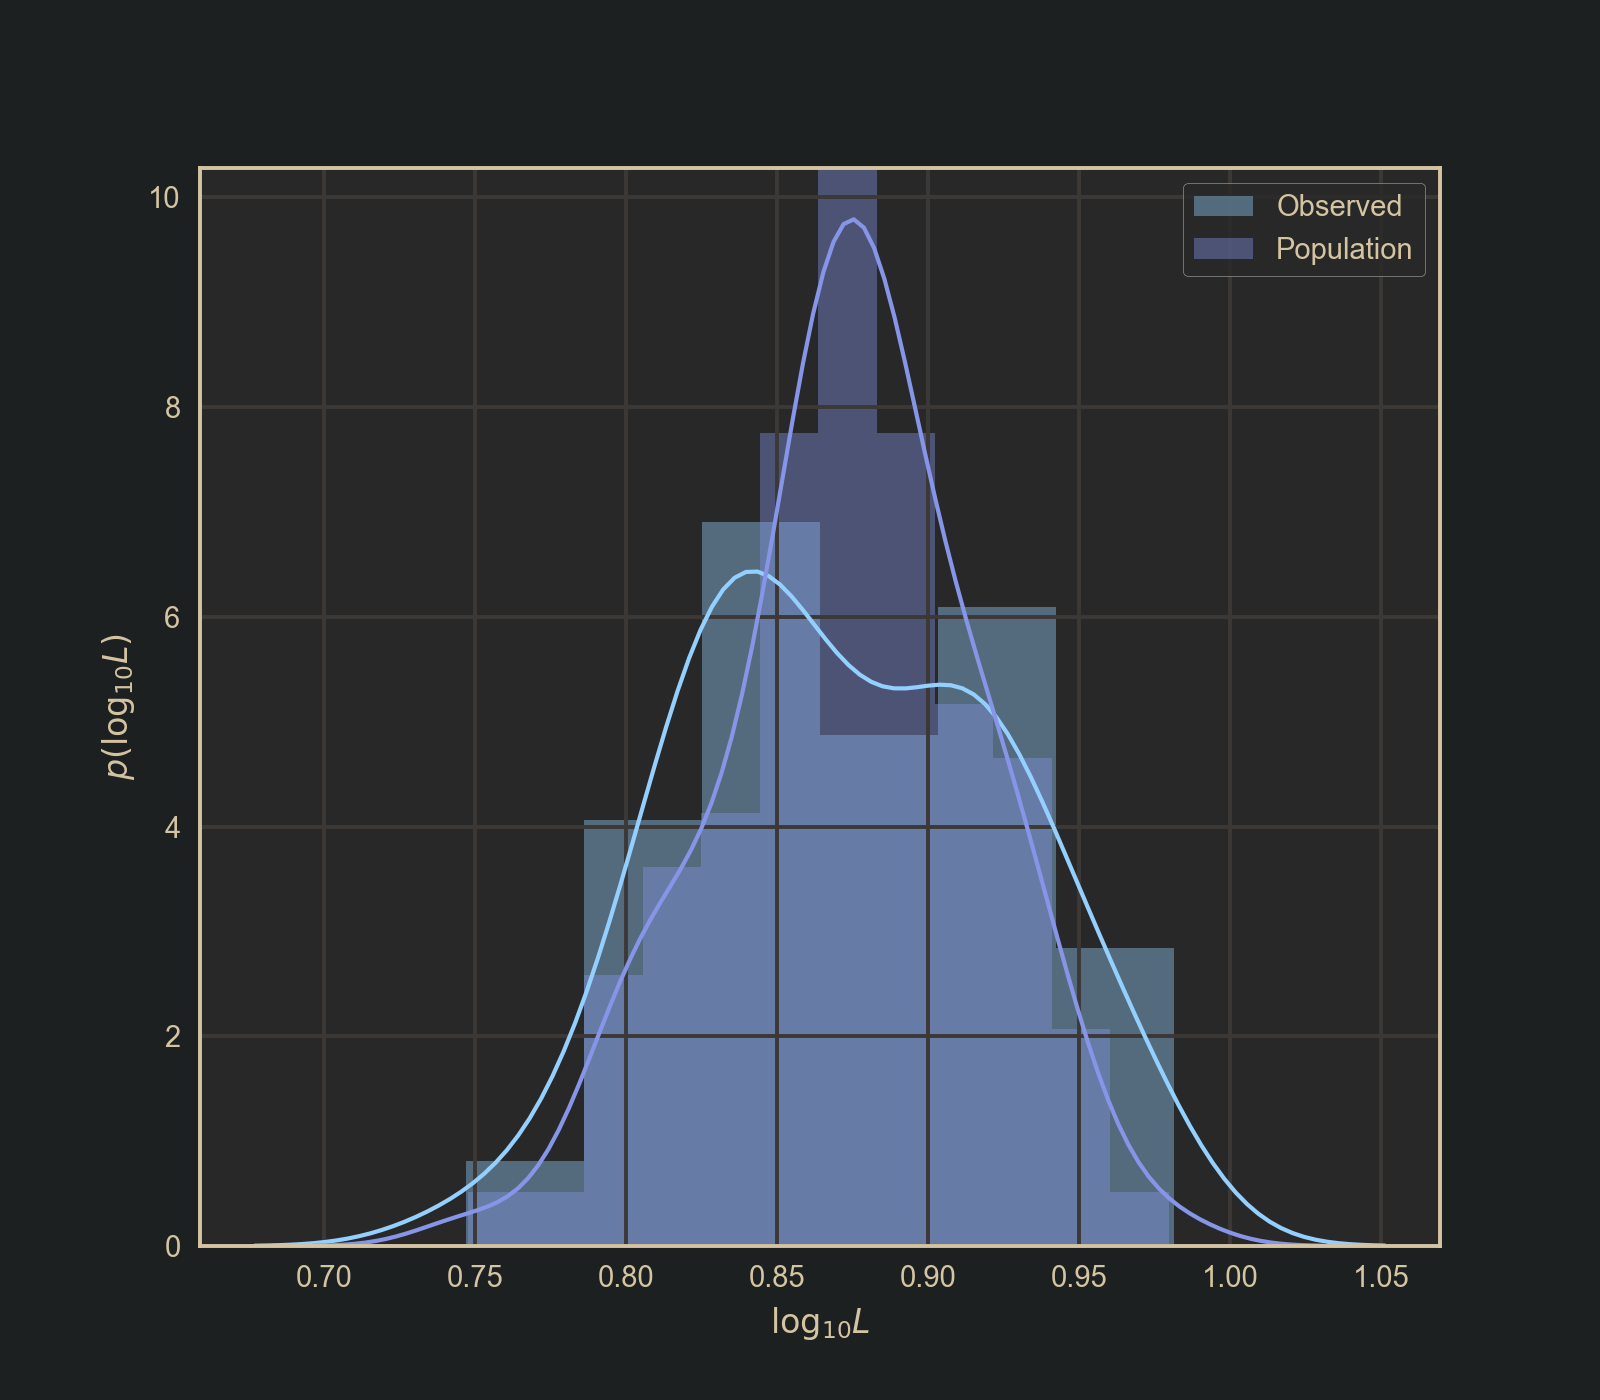

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\log_{10} L\\right)$')

In [10]:
fig, ax = plt.subplots()

sns.distplot(np.log10(Ls), label="Observed")
sns.distplot(np.log10(draw_luminosity(mu_true, sigma_true, size=100)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} L$')
ax.set_ylabel(r'$p\left( \log_{10} L\right)$')

<IPython.core.display.Javascript object>


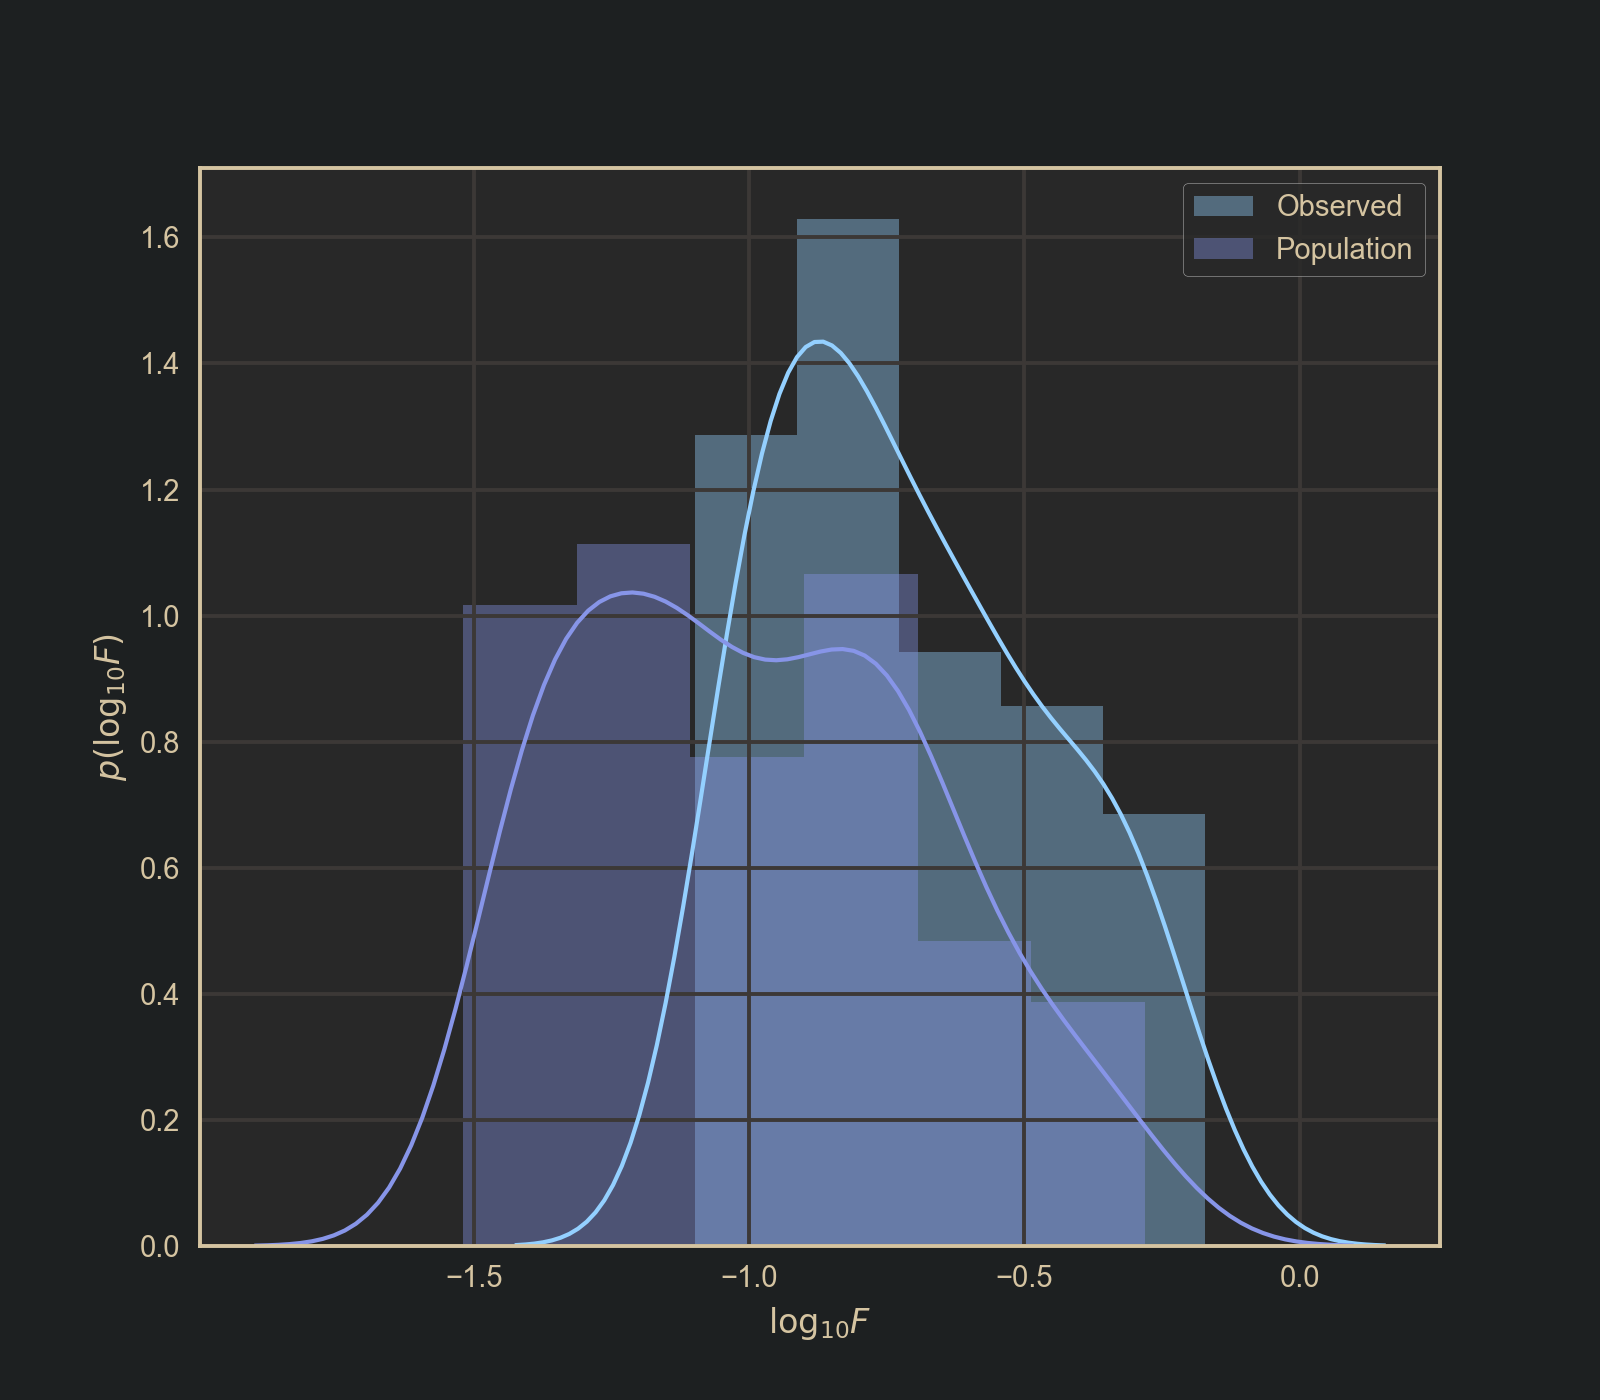

Text(0,0.5,'$p\\left( \\log_{10} F\\right)$')

In [11]:
fig, ax = plt.subplots()

sns.distplot(np.log10(Fobs), label="Observed")
nn=100
zzz= draw_redshift(zmax,size=nn)
sns.distplot(np.log10(draw_fobs(draw_luminosity(mu_true, sigma_true, size=nn),zzz,size=nn)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} F$')
ax.set_ylabel(r'$p\left( \log_{10} F\right)$')

<IPython.core.display.Javascript object>


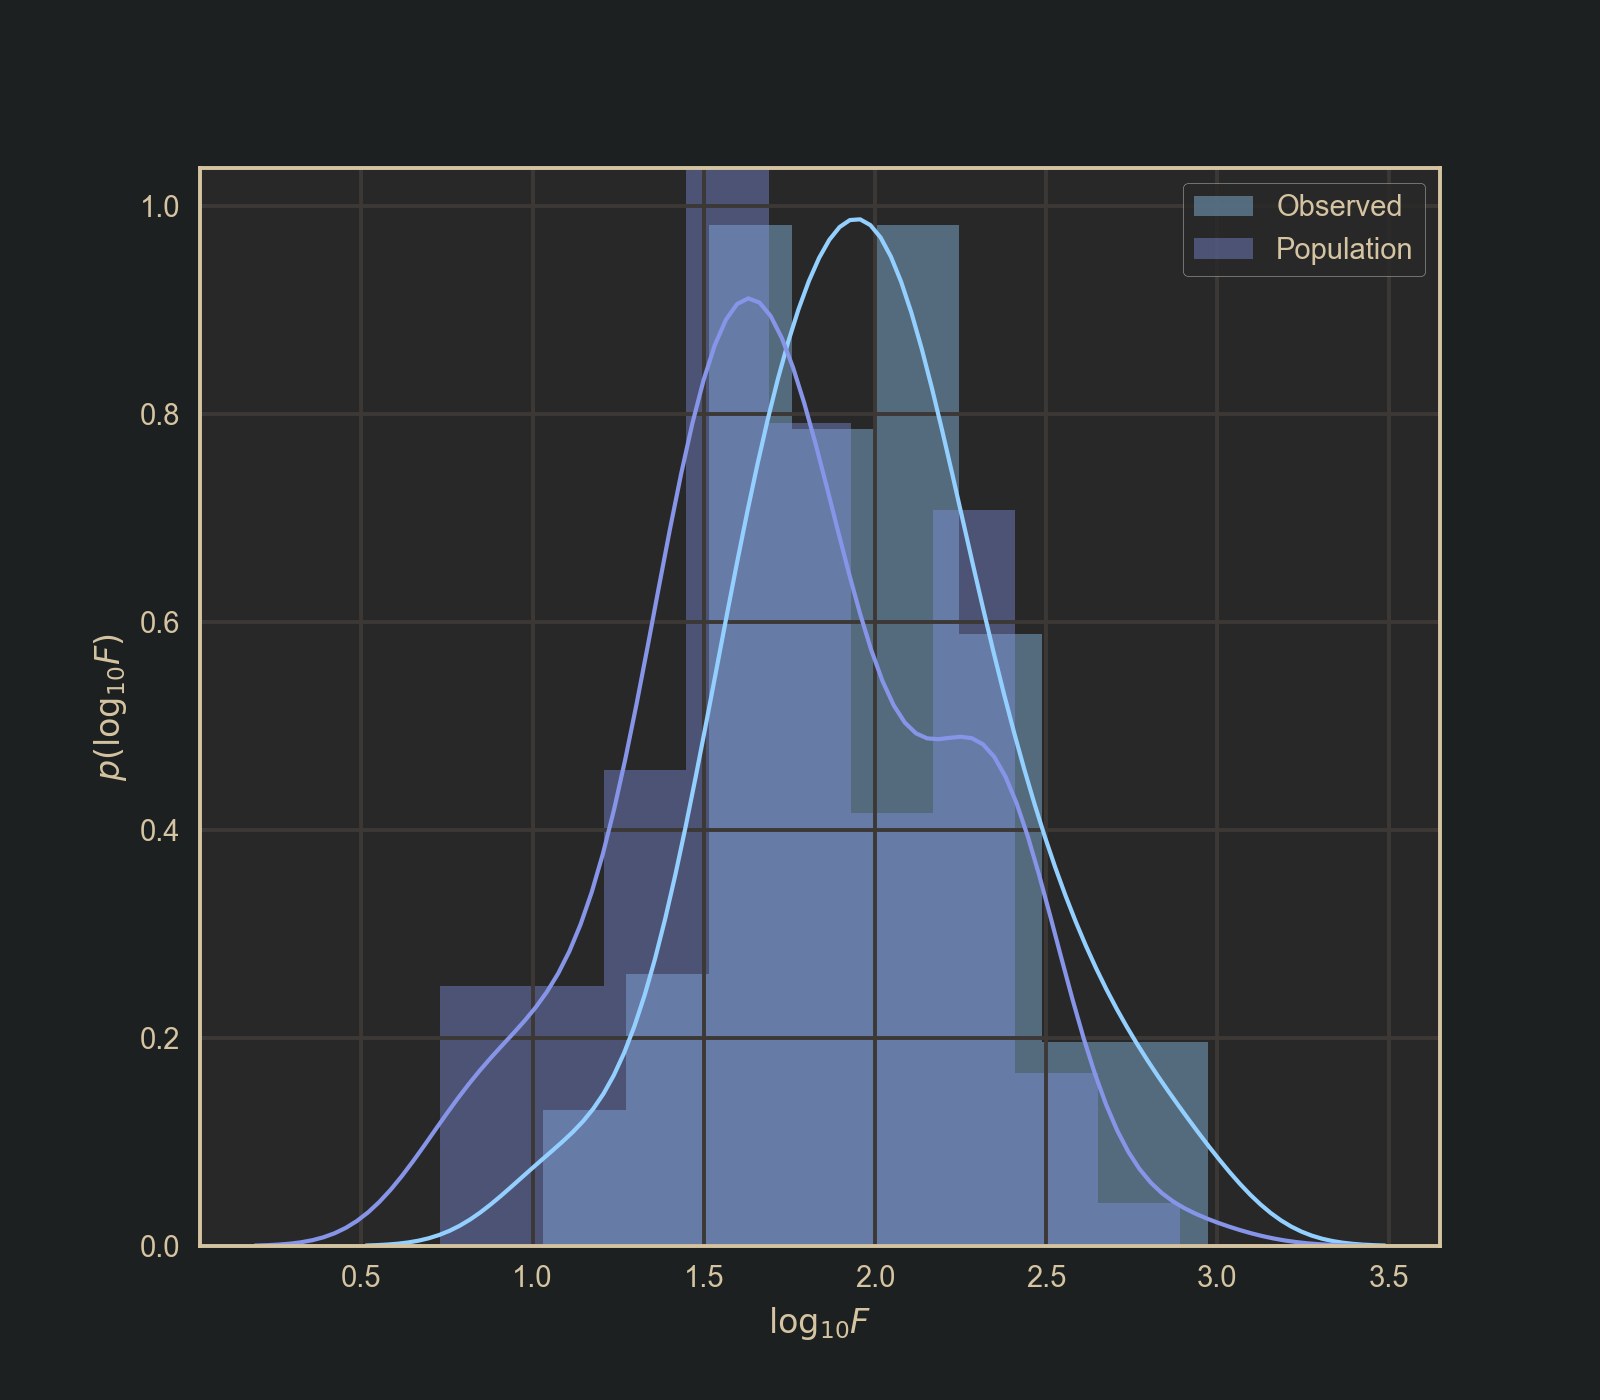

Text(0,0.5,'$p\\left( \\log_{10} F\\right)$')

In [12]:
fig, ax = plt.subplots()

sns.distplot(np.log10(epobs), label="Observed")
nn=100
zzz= draw_redshift(zmax,size=nn)
sns.distplot(np.log10(draw_epobs(draw_ep(E0_true, esigma_true, size=nn),zzz,size=nn)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} F$')
ax.set_ylabel(r'$p\left( \log_{10} F\right)$')

<IPython.core.display.Javascript object>


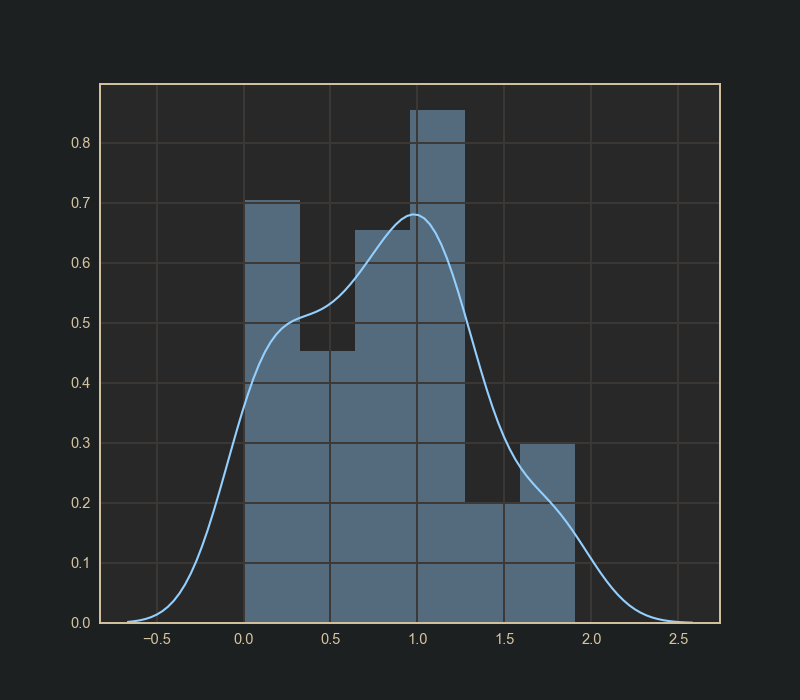

In [17]:
fig, ax = plt.subplots()

sns.distplot(zobs)


In [10]:
model_uk = pystan.StanModel(file='gaussian2d_ukz.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9165a9fc01371e47f932c649c9e9e0e5 NOW.


In [11]:
fit_ukz = model_uk.sampling(
    data = {'Nobs': len(Ls), 
            'Fobs': Fobs,
            'epobs': epobs,
            #'zobs': zobs,
            'NNobs_max': 100, 
            'Funcert': 0.05, 
            'Euncert': 0.05, 
            'zmax': zmax,
            'Fth': Fth,
           'eth':eth
           
           },
    iter = 24000,
    #chains=4,
    #warmup=4000,
    thin = 6,
    seed=1234
)

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


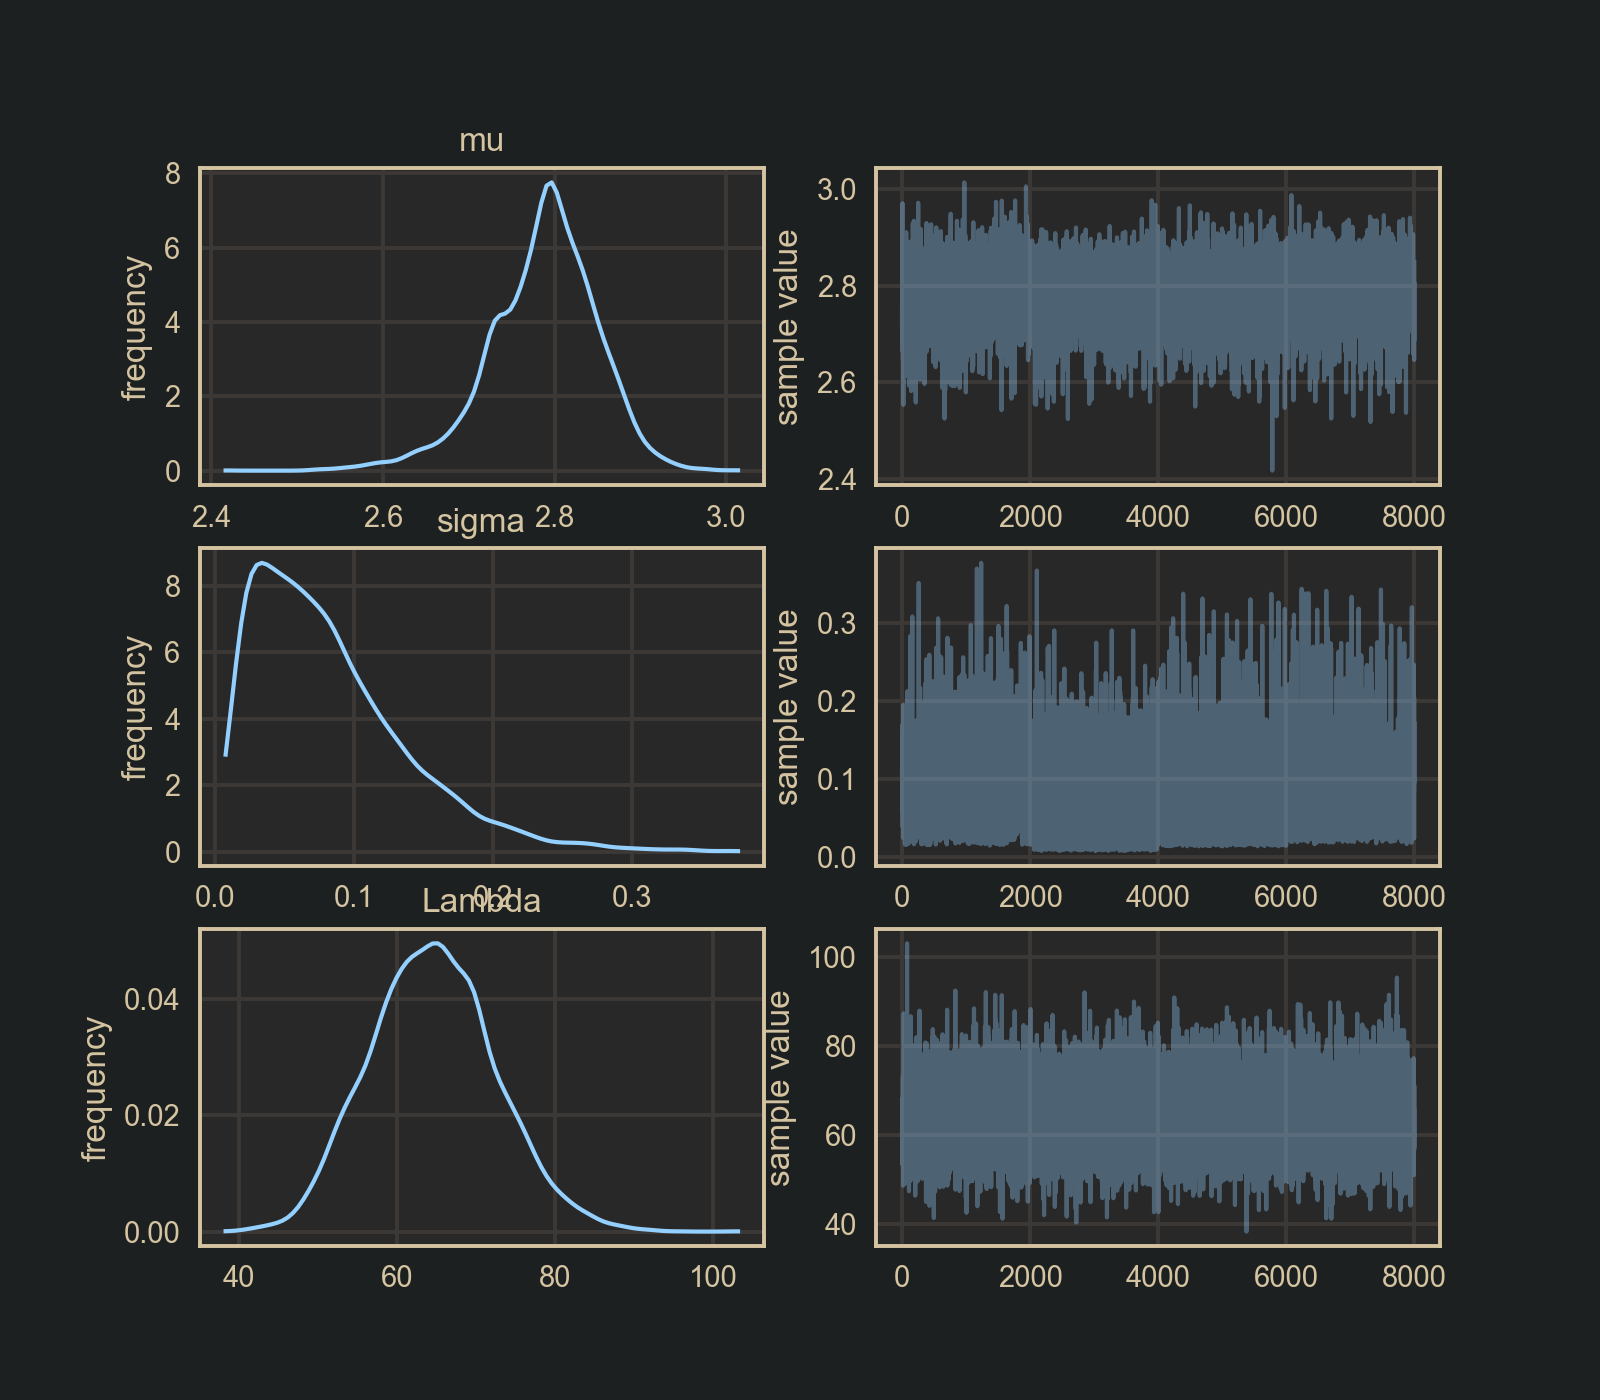

In [12]:
fit_ukz.plot(['mu', 'sigma', 'Lambda']);

<IPython.core.display.Javascript object>


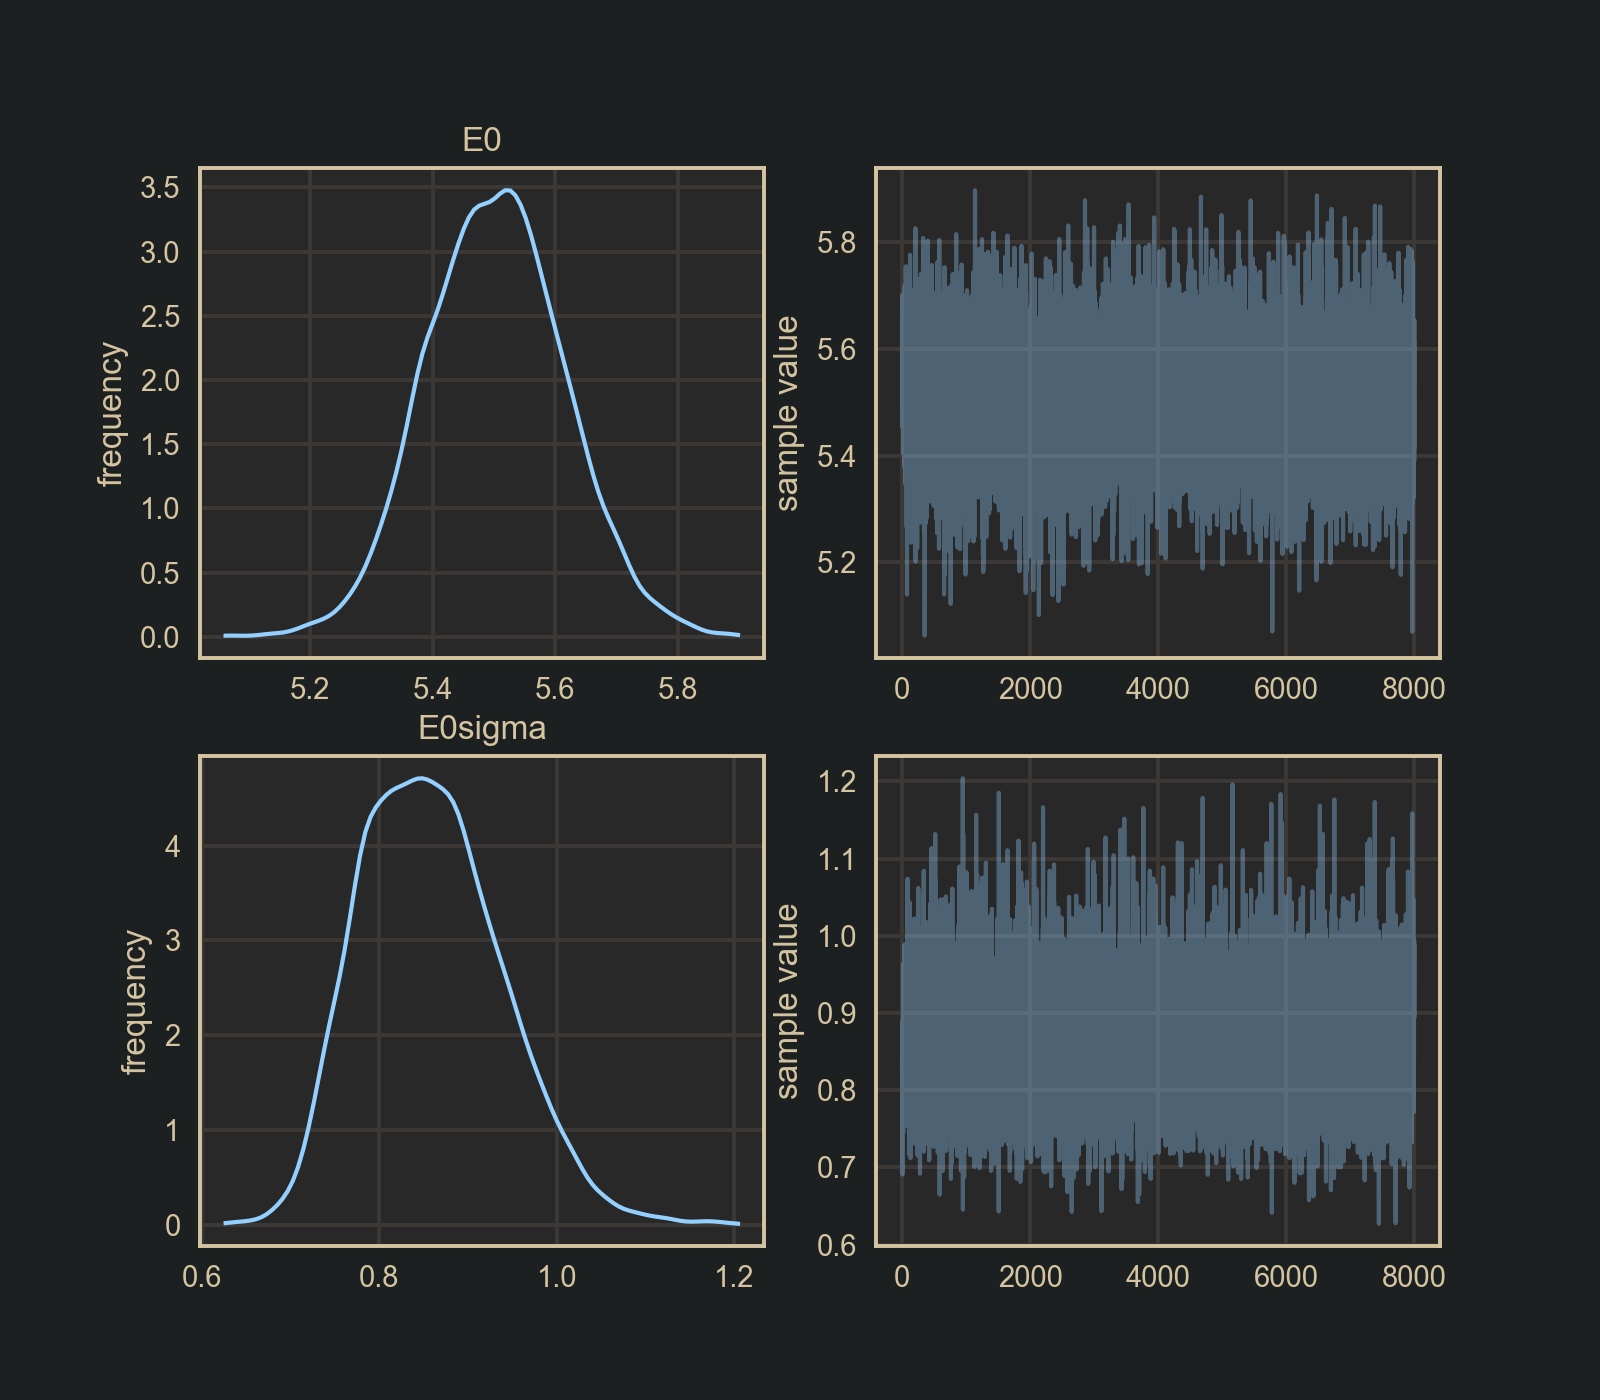

In [13]:
fit_ukz.plot(['E0', 'E0sigma']);

In [14]:
chain_selected = fit_ukz.extract(permuted=True)

<IPython.core.display.Javascript object>


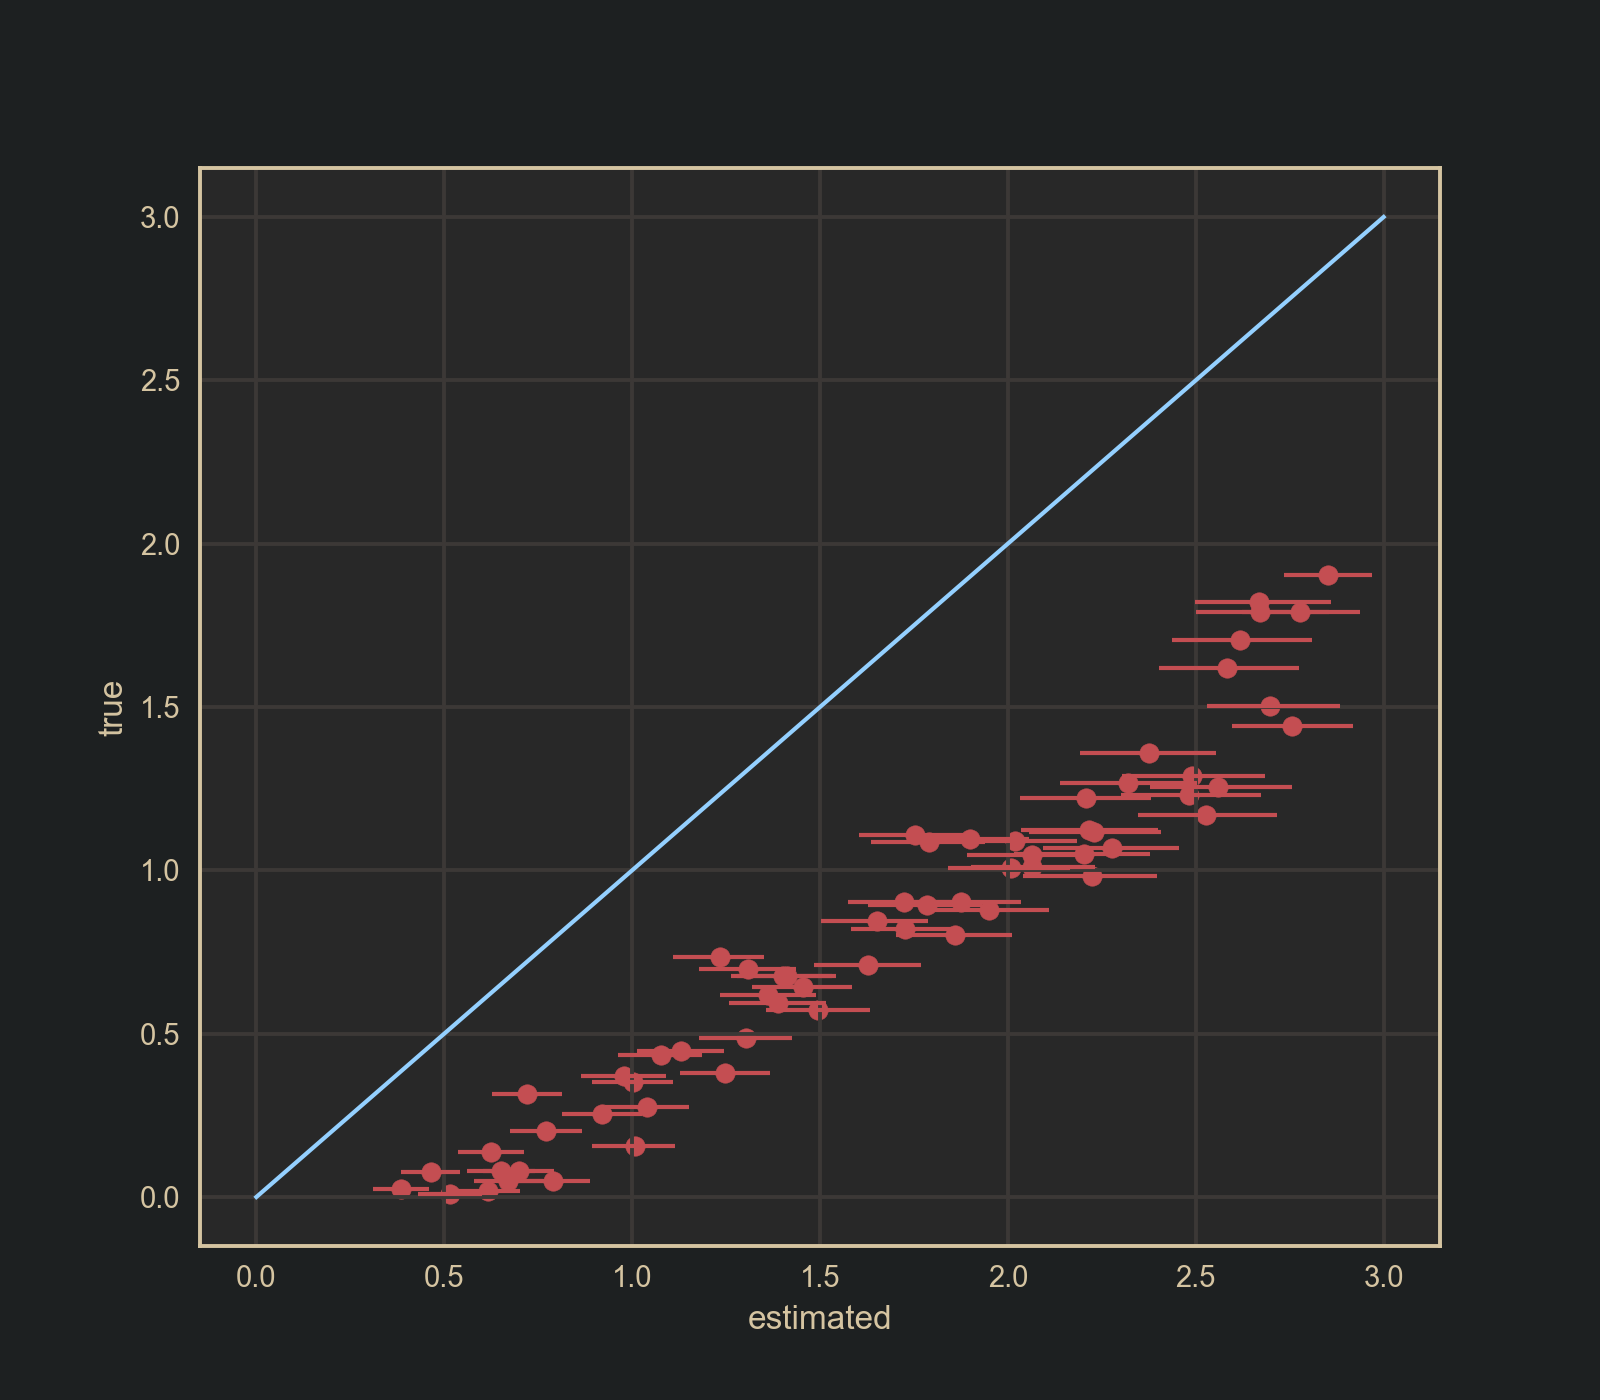

Text(0,0.5,'true')

In [15]:
fig, ax = plt.subplots()

ax.scatter(chain_selected['ztrue'].mean(axis=0),zobs,c='r')

ax.plot([0,3], [0,3])


ax.hlines(zobs, np.percentile(chain_selected['ztrue'], 16, axis=0),
          np.percentile(chain_selected['ztrue'], 84, axis=0),colors='r')

ax.set_xlabel('estimated')
ax.set_ylabel('true')

<IPython.core.display.Javascript object>


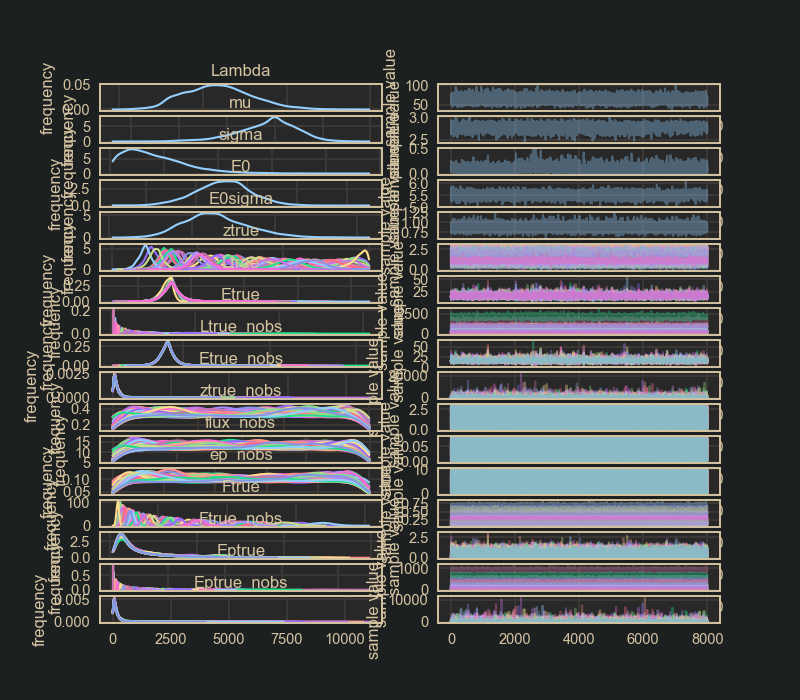

In [35]:
fit_ukz.plot();

In [17]:
eth

10

In [22]:
zobs

array([1.23155936, 0.57302087, 0.07572707, 0.80071744, 0.20234591,
       0.70938719, 1.12287655, 0.64203574, 0.3163376 , 0.69743936,
       0.90183041, 0.84370434, 1.08683028, 0.01782853, 1.09715738,
       0.48604751, 1.79229933, 0.87945741, 0.07858982, 0.04835589,
       0.38087409, 0.1376857 , 1.28944001, 1.067873  , 0.44633297,
       0.37176903, 1.7894607 , 0.04917744, 0.02321254, 0.25446683,
       0.67649523, 1.09072895, 1.61987981, 1.70430964, 0.67639008,
       0.89473618, 1.25588058, 1.35926677, 1.50168426, 0.01059663,
       1.44266713, 0.59509707, 0.1562734 , 1.22033668, 1.11718944,
       0.07983335, 1.82258721, 1.00663162, 1.04869868, 1.16962269,
       1.10787352, 1.04639195, 1.90391421, 0.82152663, 0.61834539,
       1.00901859, 0.98129968, 1.26763006, 0.73509912, 0.35219531,
       0.90316007, 0.4357912 , 0.27655829])

<IPython.core.display.Javascript object>


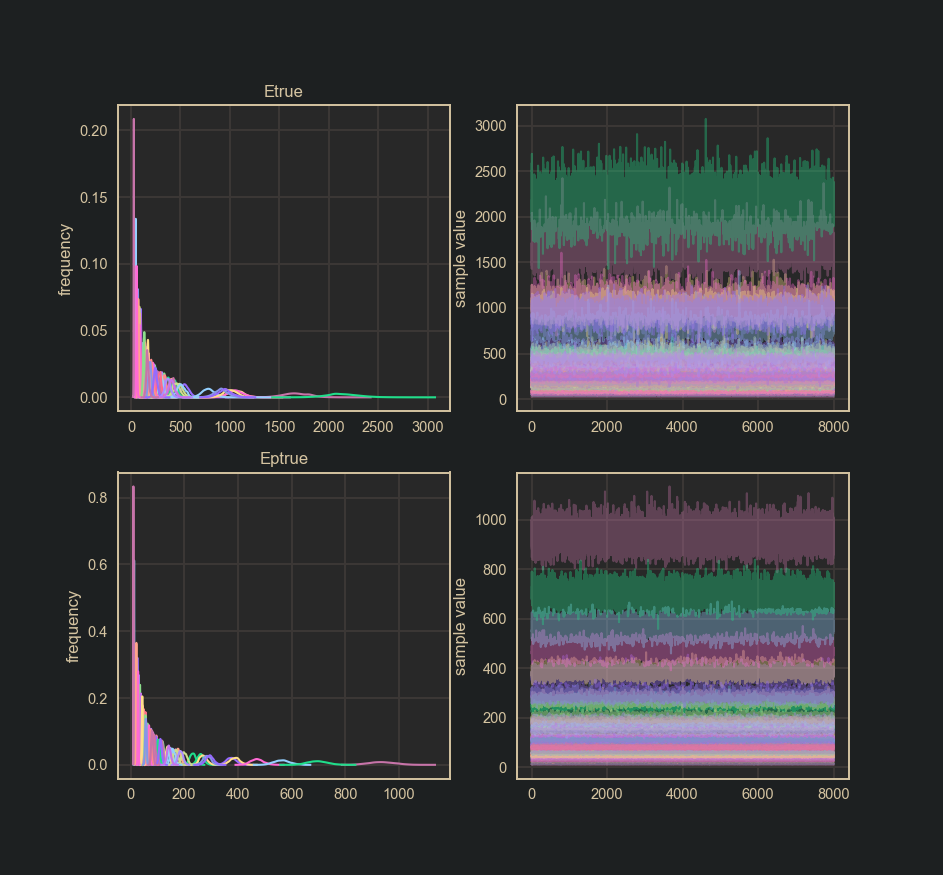

In [36]:
fit_ukz.plot(['Etrue','Eptrue']);

In [40]:
np.exp(5.7)

298.8674009670603

In [18]:
epobs

array([ 13.21219808,  56.29658888, 376.65172423, 110.25071916,
        86.20726459,  10.73340708,  53.03801561,  54.64161642,
       116.5523481 , 178.71670778, 390.59499271, 184.88020291,
       119.14807205, 231.70388336,  41.24735474,  30.52015791,
        25.8710394 , 108.39321169, 168.28527365, 937.90619661,
       474.24378202,  55.96638194,  96.60222615,  57.01206123,
       138.37957067,  42.67026042,  63.9179445 , 260.961376  ,
       563.61931908, 103.09346806,  95.51474559,  76.22369064,
       116.09921101, 115.84852092,  36.16980495,  79.04346965,
        48.43285584,  21.6787292 , 272.64928347, 199.313083  ,
        35.45021477, 103.86655251, 148.02930324, 285.24561774,
       296.43854722,  83.24973956,  38.73894122,  88.38972779,
        68.28804257,  80.80596842,  75.89996884,  45.19959672,
        43.76919451, 169.63412634,  55.68548541, 703.56937447,
       156.97128091,  57.10048432, 111.58389279, 185.91716734,
       143.24666592,  80.56429316,  28.17412478])

In [38]:
Es

array([  29.8024396 ,   96.76839102,  408.60096903,  196.12277302,
        106.43396274,   19.58872679,  112.64192545,   85.44662641,
        167.46047665,  313.63052377,  741.51172057,  334.40115327,
        244.62835607,  238.49475009,   84.4429424 ,   49.40031928,
         69.65557852,  204.72888177,  205.09408967,  903.22357121,
        677.80905849,   65.14194082,  234.22235406,  116.78460072,
        191.29494977,   53.53549699,  175.55322888,  258.23142165,
        588.31203733,  128.61507459,  151.45915706,  169.6990871 ,
        300.20755158,  288.77661707,   60.43552289,  160.64982787,
        112.79854347,   51.98776085,  646.73030541,  201.8216161 ,
         80.54166754,  170.71203073,  162.95283929,  638.79862779,
        599.05471015,   85.74329339,  104.08163487,  177.18463584,
        144.03149529,  181.19650604,  180.73266176,  105.50288345,
        119.34921052,  299.85832641,   81.60533736, 1340.37150789,
        295.39012203,  134.93557749,  196.11152779,  264.95012

In [41]:
2500/4

625